## Random Forests

As always, let's begin by importing our handy dandy pandas package. Today, we'll also be using numpy.

In [69]:
import pandas as pd
import numpy as np

Today, we're using the same data as last week about **shark attacks**. As a reminder, we're using this dataset to build a model that predicts whether a shark attack is fatal based on various factors. The dataset includes details such as the year, location (country), activity at the time of the attack, sex and age of the individual, and species of the shark involved.

Our target variable is `fatal_y_n`, which indicates whether an attack was fatal (Y) or not (N). By analyzing patterns in the data, we aim to identify key factors that contribute to the severity of shark attacks and build a predictive model that helps assess risk.

To improve our model’s performance, we’ll preprocess the data, encode categorical variables, and fine-tune hyperparameters to avoid overfitting. Let’s dive in!

In [70]:
df = pd.read_csv('shark_attacks.csv')
print(df.shape)
df.iloc[:5]

(1530, 8)


,year,type,country,activity,sex,age,species,fatal_y_n
0,2023.0,Unprovoked,AUSTRALIA,Surfing,M,46,Large Predatory Sharks,Y
1,2022.0,Unprovoked,AUSTRALIA,Spearfishing,M,38,Large Predatory Sharks,N
2,2021.0,Unprovoked,USA,Surfing,M,25,Other Category,N
3,2021.0,Unprovoked,USA,Swimming,M,26,Small Sharks (Size-Based),N
4,2021.0,Unprovoked,USA,Surfing,M,14,Other Category,N


Again, we will need to convert this `"Y"` or `"N"` into a 1 or 0 so the random forest model can actually make predictions. This calls for a lambda function!

In [71]:
df['fatal_y_n'] = df['fatal_y_n'].apply(lambda x: 1 if x == "Y" else 0 if x == "N" else np.nan)

#### Practice Problems

1. What are the most common countries that appear in the data?

In [72]:
# Answer here:
df['country'].value_counts()

country
USA                 828
AUSTRALIA           355
SOUTH AFRICA        196
BRAZIL               46
NEW ZEALAND          36
BAHAMAS              30
PAPUA NEW GUINEA     21
MEXICO               18
Name: count, dtype: int64

2. Do we have any NA values in this data to worry about?

In [73]:
# Answer here:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1530 non-null   float64
 1   type       1530 non-null   object 
 2   country    1530 non-null   object 
 3   activity   1530 non-null   object 
 4   sex        1530 non-null   object 
 5   age        1530 non-null   int64  
 6   species    1530 non-null   object 
 7   fatal_y_n  1530 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 95.8+ KB


### Modeling with Random Forest

In [74]:
from sklearn.model_selection import train_test_split # to create training and testing data
from sklearn.ensemble import RandomForestClassifier  # to build a random forest model
from sklearn.tree import plot_tree # to plot the random forest
import matplotlib.pyplot as plt # for data visualization purposes
from sklearn.metrics import roc_auc_score # to evaluate model using ROC AUC

Remember from last week that there's an important step we must follow before we begin modeling. If you try to feed a column with text values (e.g., `"red"`, `"blue"`, `"green"`) into a random forest, it won’t know how to process the data. This is where `pd.get_dummies()` comes in.

**What `get_dummies` Does**

get_dummies is a pandas function that converts categorical variables into a numerical format using one-hot encoding (changing categories into a 1 or 0). It creates separate binary columns for each unique category, allowing models like decision trees to interpret categorical data correctly.

**Why This Matters for Random Forests**

Each tree within a random forest will split data based on feature values, so categorical data must be represented numerically. Encoding categories properly ensures the model makes meaningful splits rather than treating categories as arbitrary numbers.

By using `pd.get_dummies()`, you make categorical data decision-tree-friendly, improving model accuracy and interpretability.

In [75]:
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.iloc[:5]

,year,age,fatal_y_n,type_Sea Disaster,type_Unprovoked,type_Watercraft,country_BAHAMAS,country_BRAZIL,country_MEXICO,country_NEW ZEALAND,...,country_SOUTH AFRICA,country_USA,activity_Spearfishing,activity_Surfing,activity_Swimming,sex_M,species_Large Sharks (Size-Based),species_Other Category,species_Other Named Sharks,species_Small Sharks (Size-Based)
0,2023.0,46,1,False,True,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1,2022.0,38,0,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
2,2021.0,25,0,False,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,False
3,2021.0,26,0,False,True,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True
4,2021.0,14,0,False,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,False


Now that we have our dummy variables, we're ready to move on to our next step. Remember that no matter what Machine Learning algorithm we use, we **MUST** perform a Train-Test Split. This is all about making predictions, so we need to test our model on data it hasn't seen.

In [76]:
X = df_dummy.drop(columns = ['fatal_y_n'])
y = df_dummy['fatal_y_n']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 412)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1071, 20)
(459, 20)
(1071,)
(459,)


And *now* we can move on to the actual modeling part.

Random Forests introduce an additional layer of randomness by not utilizing all available features when forming each tree in its ensemble. Additionally, only a random subset of features is evaluated at each split in the tree, which decreases the chance of the model relying on the same feature to capture a spurious pattern across numerous trees.

**As a result, we end up exploring trees we may never come across using a standard, greedy approach while also reducing correlation between trees. This reduces variations in predictions without comprising individual accuracy.**

When creating a random forest model, here are some of the estimators we can specify:

First, we have the same two hyperparameters from decision trees. These can be applied to each tree in the forest:
- The minimum samples required in a leaf node through `min_samples_leaf`
- The maximum depth for each tree, through `max_depth`

We also have some new hyperparameters specific to random forests:
- The maximum number of random features to consider when looking for the best next split in a tree, through `max_features`
- The number of trees in the forest through `n_estimators`

Typically speaking, the `max_depth` and `n_estimators` hyperparameters have the biggest effect on model performance.

Let's instantiate and evaluate a random forest that: 
- makes splits to maximize entropy
- has 100 trees in the forest
- has a maximum depth of 3 splits in each tree
- picks 6 random reatures to consider when looking for each next best split for each tree.

In [77]:
rf_model = RandomForestClassifier(criterion = 'entropy', n_estimators = 10000, max_depth = 4, max_features = 2)
rf_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=2,
                       n_estimators=10000)

While a Random Forest consists of multiple decision trees, we can only visualize one tree at a time. This is because a Random Forest is an **ensemble model**, meaning it makes predictions by averaging the outputs of many trees, rather than relying on a single tree's decision path. However, we can still extract and plot an individual tree from the forest to understand its structure, decision rules, and feature splits.

Notice that when you view different trees in the forest (by changing the [0] to different numbers in line 2), there are different splits made each time. This is because of the `max_features` hyperparameter. For each tree, it's randomly choosing 6 variables and pretending only those 6 variables exist. This constraint of available features is what makes each of the 100 trees produce different splits, and therefore different predictions.

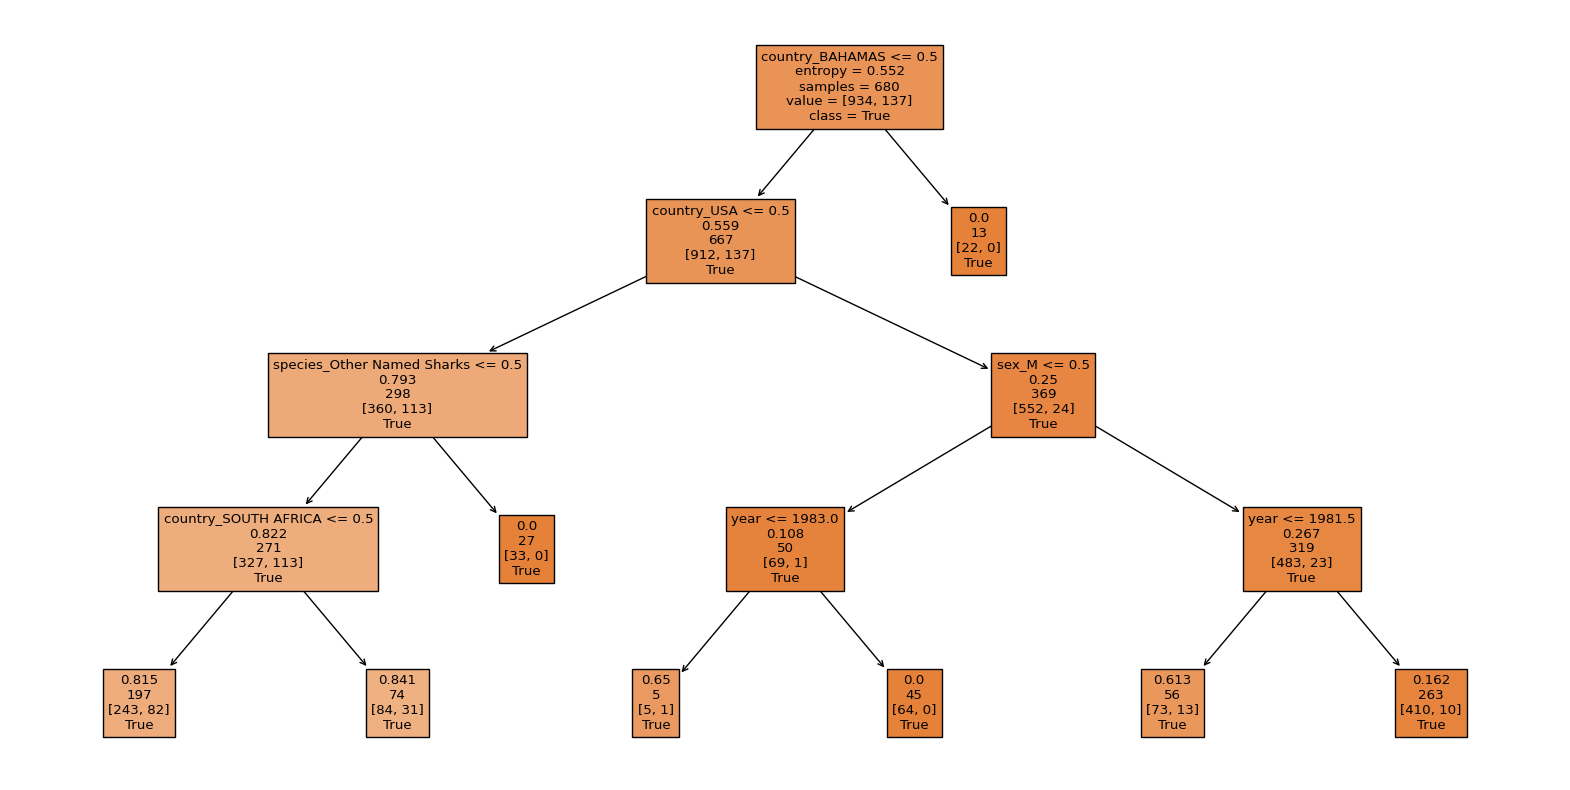

In [78]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[3], impurity = True, feature_names = X_train.columns.tolist(), class_names=['True','False'], label = "root", filled=True)
plt.show()

And finally, we get to see how the model performed! If you'll remember from last week, the single decision tree with the best hyperparameters led to a ROC AUC of just under 0.85. Did our random forest model do better than that? Let's see...

In [79]:
y_probs = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8831


### **Competition Time!**

Try a few different values for the hyperparameters listed above and let's see who can get the highest value for ROC AUC!

In [80]:
# Answer here:
